In [1]:
%matplotlib inline

In [2]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
path = r"M:\pc\Dokumenter\Notebooks\EpEg"
path = os.path.join(path, "")

In [4]:
name = "plasmon peak mapping-color range18-19 - bin2.dm3"

In [5]:
s = hs.load(path + name)

### Let's take a look at the data:

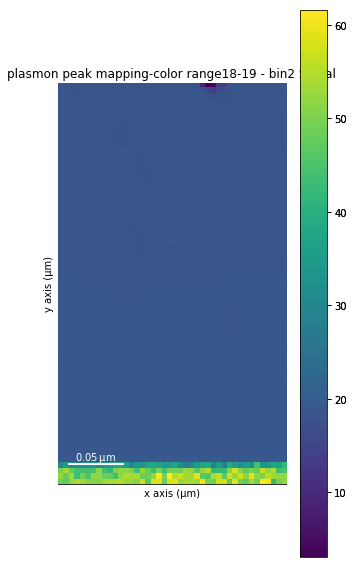

In [6]:
s.plot(cmap="viridis")

Note that there is a hole in the top-right of the image. In order to keep the color limits ok, I'm cropping out the top few pixels of the image.
Since the bottom apparently is substrate, I crop out that as well:

In [10]:
#s = s.isig[:,5:-5]

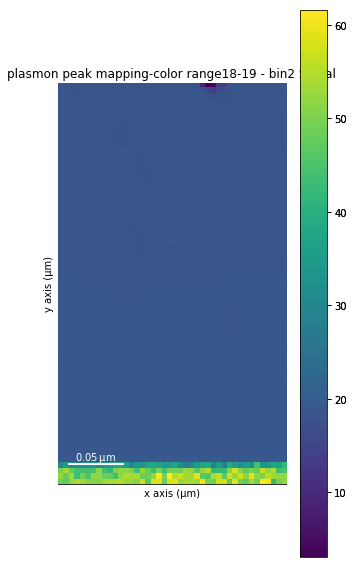

In [7]:
s.plot(cmap="viridis")

### To see, the Ep values in the top and bottom of the image are:

In [8]:
s.data

array([[ 18.40647697,  18.40217018,  18.32034302, ...,  18.41176224,
         18.4259491 ,  18.46411514],
       [ 18.41669083,  18.39990807,  18.33735657, ...,  18.40891075,
         18.44997787,  18.38216972],
       [ 18.42376518,  18.39284897,  18.3355217 , ...,  18.42285538,
         18.41974449,  18.44116211],
       ..., 
       [ 50.03587723,  53.2297821 ,  47.78347397, ...,  54.66207504,
         43.57122421,  44.76358032],
       [ 52.40639496,  47.893013  ,  53.13335037, ...,  52.7975769 ,
         52.13801193,  52.18047714],
       [ 48.26553726,  47.33177185,  52.22529602, ...,  42.41243362,
         49.39396667,  51.32452393]], dtype=float32)

### Settings constants for the relation Eg -> Ep

In [9]:
a = 129.25
b = 47.608
c = 4.47327
e = 3.38799
f = -1.40732
g = 0.513266

constants = a,b,c,e,f,g

In [10]:
def Eg_to_Ep(Eg, constants):
    import math
    
    a,b,c,e,f,g = constants
    return math.sqrt(Eg**2 + a**2*(2*b*g-c*f+math.sqrt(4*Eg*c**2*g-4*c**2*e*g+c**2*f**2))/(2*(b**2*g+c**2*e-b*c*f-Eg*c**2)))

### Duplicate signal, to change one later

In [11]:
Ep_signal = s
Eg_signal = s.deepcopy()

In [12]:
Ep = Eg_signal.data

### Find range of Ep values we need to convert to we need for a numerical solution:

In [13]:
print("Min", Ep.min())
print("Max", Ep.max())

Min 3.0504
Max 61.6128


In [14]:
Egvalues = np.arange(2.5,76,0.001) # 2.5 is the minimum Eg value, 76 seems to be the max - outside of this range the equation gives NaNs.
EgtoEpConversionArray = np.array([Eg_to_Ep(i, constants) for i in Egvalues])

### Let's see what our Eg -> Eg equation looks like:

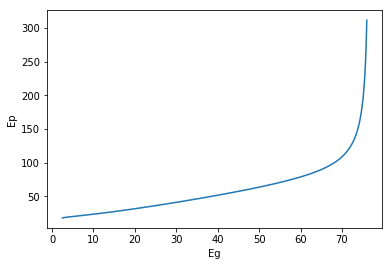

In [15]:
plt.plot(Egvalues,EgtoEpConversionArray,)
plt.xlabel("Eg")
plt.ylabel("Ep")

### Note that we are in the extreme bottom left regime of this plot, and the relation is nearly linear, so it is more like this for us:

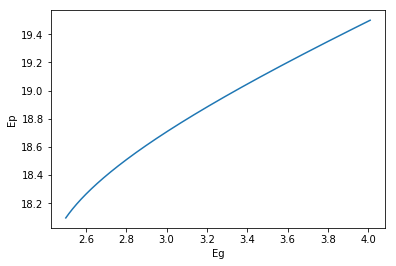

In [16]:
ourEgvalues = Egvalues[EgtoEpConversionArray < 19.5]
ourEpvalues = EgtoEpConversionArray[EgtoEpConversionArray < 19.5]
plt.plot(ourEgvalues,ourEpvalues,)
plt.xlabel("Eg")
plt.ylabel("Ep")
# I've just zoomed into the bottom left of the plot

In [17]:
np.diff(EgtoEpConversionArray).min() # Derivative is never negative, good - means that there can't be multiple values of Eg for a given Ep

0.00066359479534483512

### Let's find the first value in the Ep table equal to our pixel value, and use that index in the Eg table:

In [18]:
def func(Epvalue, Epvalues, EpEgConversionArray):
    import numpy as np
    Egvalue = Egvalues[np.where(EgtoEpConversionArray >= Epvalue)[0][0]]
    return Egvalue

In [19]:
print("These are the minimum and max Eg values found:")
print("Min", func(Ep_signal.data.min(), Egvalues, EgtoEpConversionArray))
print("Max", func(Ep_signal.data.max(), Egvalues, EgtoEpConversionArray))

These are the minimum and max Eg values found:
Min 2.5
Max 48.327


In [20]:
for x in np.nditer(Ep, op_flags=['readwrite']):
    x[...] = func(x, Egvalues, EgtoEpConversionArray)

In [21]:
Eg_signal.save(path + "Eg_values.tif")

In [22]:
import scipy.io
scipy.io.savemat(path+"Eg.mat", mdict={'arr': Eg_signal.data})


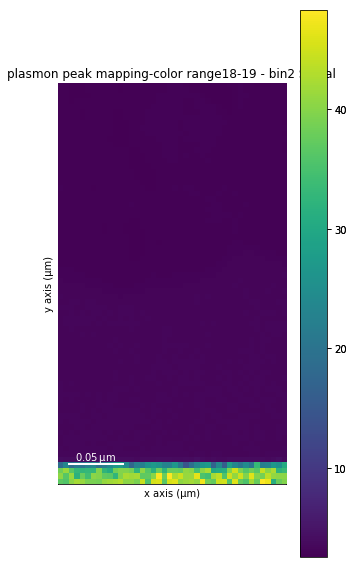

In [23]:
Eg_signal.plot(cmap="viridis")

### As we see below, the Eg values range from 2.7 in the top of the image, to varying around 38 in the bottom part of the image

In [24]:
Eg_signal.data

array([[  2.71000004,   2.70600009,   2.64100003, ...,   2.71399999,
          2.727     ,   2.75999999],
       [  2.7190001 ,   2.704     ,   2.65400004, ...,   2.71199989,
          2.74699998,   2.69000006],
       [  2.7249999 ,   2.69899988,   2.65300012, ...,   2.72399998,
          2.72099996,   2.74000001],
       ..., 
       [ 38.43199921,  41.29800034,  36.35400009, ...,  42.55099869,
         32.33800125,  33.49200058],
       [ 40.56800079,  36.45600128,  41.21300125, ...,  40.91600037,
         40.32899857,  40.36700058],
       [ 36.80199814,  35.93099976,  40.4070015 , ...,  31.20299911,
         37.84500122,  39.59999847]], dtype=float32)